In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import linregress as linR
from scipy.optimize import minimize

# Прототип генерации блуждания и подсчёта соседей по нему

In [ ]:
np.random.randint(0,4, size=10)

array([2, 2, 2, 1, 3, 3, 2, 1, 2, 0])

Основные константы - начальная точка и шаги блуждания

In [ ]:
x0 = np.array([0,0])
steps = np.array([[1,0],[-1,0],[0,1],[0,-1]])

Генерация блужданий и определение уникальных узлов

In [ ]:
N=100
walk_directions = np.random.randint(0,4, size=N)
walk_dots = np.zeros((N, 2), dtype=np.int16)
walk_dots[0] = x0

for i in range(1,N):
    walk_dots[i] = walk_dots[i-1] + steps[walk_directions[i]]

walk_dots_new = np.unique(walk_dots, axis=0)
N_new = len(walk_dots_new)

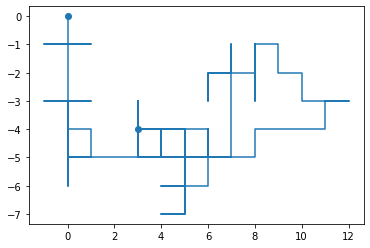

In [ ]:
plt.plot(walk_dots[:,0], walk_dots[:,1])
plt.scatter(walk_dots[(0,-1),0], walk_dots[(0, -1),1])

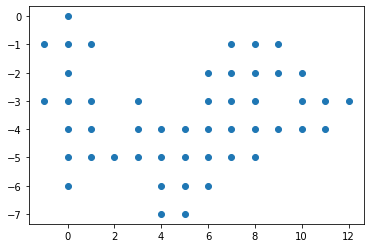

In [ ]:
plt.scatter(walk_dots_new[:,0], walk_dots_new[:,1])

Подсчёт соседей среди уникальных узлов

In [ ]:
walk_neighbors = np.zeros((N_new,), dtype=np.int8)
for i in range(N_new):
    for step in steps:
        potential_n = walk_dots_new[i] + step
        for j in range(N_new):
            if (walk_dots_new[j] == potential_n).all():
                walk_neighbors[i] += 1
                break

In [ ]:
walk_neighbors

array([1, 1, 1, 3, 3, 4, 2, 4, 1, 3, 3, 2, 1, 2, 3, 3, 1, 2, 3, 4, 3, 2,
       4, 4, 3, 2, 4, 4, 3, 2, 3, 4, 4, 4, 2, 2, 4, 3, 4, 3, 2, 3, 2, 3,
       3, 2, 2, 3, 1], dtype=int8)

In [ ]:
neigh_fract = np.zeros((1,4), dtype=np.float)
for i in range(1,4+1):
    neigh_fract[0][i-1] = (walk_neighbors == i).sum()
neigh_fract / N_new

array([[0.14285714, 0.26530612, 0.34693878, 0.24489796]])

# Распараллеленный алгоритм

In [89]:
import numpy as np
from numba import jit



@jit
def experiment(N: int):
    x0 = np.array([0,0])
    steps = np.array([[1,0],[-1,0],[0,1],[0,-1]])
    walk_directions = np.random.randint(0,4, size=N)
    walk_dots = np.zeros((N, 2), dtype=np.int16)
    walk_dots[0] = x0
    for i in range(1,N):
        walk_dots[i] = walk_dots[i-1] + steps[walk_directions[i]]
        
    walk_dots_new = np.unique(walk_dots, axis=0)
    N_new = len(walk_dots_new)

    walk_neighbors = 0
    neigh_fract_0 = np.zeros((1,5), dtype=np.float_)
    for i in range(N_new):
        walk_neighbors = 0
        for step in steps:
            potential_n = walk_dots_new[i] + step
            for j in range(N_new):
                if (walk_dots_new[j] == potential_n).all():
                    walk_neighbors += 1
        neigh_fract_0[0][walk_neighbors-1] += 1
    neigh_fract_0 /= N_new
    neigh_fract_0[0][-1] = N_new / N
    return neigh_fract_0

def write_results(N, obs_mean, obs_std, steps):
    res_array = np.array([N])
    res_array = np.append(res_array, obs_mean)
    res_array = np.append(res_array, obs_std)
    res_array = np.append(res_array, steps)
    np.savetxt('Drunk_Sailor_N_' + str(N) + '.txt', 
               [res_array], 
               delimiter=' ', 
               fmt=['%d', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%1.6f', '%d'], 
               newline=' ', 
               header='N  n1_mean  n2_mean  n3_mean  n4_mean  uni_mean  n1_std  n2_std  n3_std  n4_std  uni_std  steps\n',
               comments='')

def save_distr(N, obs, steps):
    name = 'DS_' + str(N) + '_dists.npz'
    bs = int(max(10, 5 + np.log2(steps)))
    counts_arr = []
    bins_arr = []
    for i in range(5):
        x = obs[:, i]
        counts, bins = np.histogram(x, bs)
        counts_arr.append(counts)
        bins_arr.append(bins)
    counts_arr = np.array(counts_arr)
    bins_arr = np.array(bins_arr)
    np.savez(name, hist=counts_arr, bins=bins_arr, steps=steps)
    
    
def save_history(N, m, s, step, i):
    name = 'DS_' + str(N) + '_history.npz'
    np.savez(name, means=m, stds=s, step=step, iters=i)
        

def complex_experiment(N, step_i, stop_i):
    observables = experiment(N)
    means = np.array([])
    stds = np.array([])
    
    iters = 0
    
    while True:
        for i in range(step_i):
            observables = np.append(observables, experiment(N), axis=0)
        iters += 1
        
        obs_mean = observables.mean(axis=0)
        obs_std = observables.std(axis=0)
        
        if iters == 1:
            means = np.array([obs_mean])
            stds = np.array([obs_std])
        else:
            means = np.append(means, [obs_mean], axis=0)
            stds = np.append(stds, [obs_std], axis=0)
        
        save_distr(N, observables, iters * step_i)
        write_results(N, obs_mean, obs_std, iters * step_i)
        save_history(N, means, stds, iters, step_i)
        if iters >= stop_i:
            break

In [90]:
complex_experiment(100, 100, 100)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8276\2550013554.py:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "experiment" failed type inference due to: No implementation of function Function(<function unique at 0x0000022D48670940>) found for signature:
 
 >>> unique(array(int16, 2d, C), axis=Literal[int](0))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload in function 'np_unique': File: numba\np\arrayobj.py: Line 2088.
        With argument(s): '(array(int16, 2d, C), axis=int64)':
       Rejected as the implementation raised a specific error:
         TypingError: got an unexpected keyword argument 'axis'
  raised from D:\ProgramFiles\anaconda3\lib\site-packages\numba\core\typing\templates.py:791

During: resolving callee type: Function(<function unique at 0x0000022D48670940>)
During: typing of call at C:\Users\Admin\AppData\Local\Temp\ipykernel_8276\2550013554.py (16)


File "..\..

In [91]:
data = np.load('DS_100_history.npz')

<ErrorbarContainer object of 3 artists>

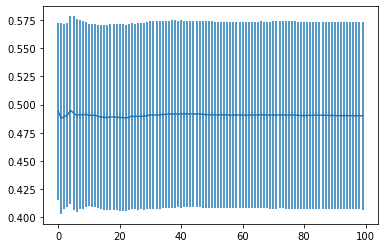

In [110]:
plt.errorbar(np.repeat([np.arange(data['iters'])], 5, axis=0)[4], data['means'].T[4], data['stds'].T[4] )

In [ ]:
for N in [100, 200, 500, 750, 1000, 2000]:
    print(N, complex_experiment(10000, N))

100%|██████████| 10000/10000 [00:12<00:00, 784.47it/s]


100 (array([0.06784209, 0.33472285, 0.35761886, 0.2398162 ]), array([0.03329051, 0.08660281, 0.06659357, 0.09192897]))


100%|██████████| 10000/10000 [00:30<00:00, 323.09it/s]


200 (array([0.05252419, 0.29084858, 0.35422398, 0.30240324]), array([0.02219834, 0.07080206, 0.05464862, 0.08984867]))


100%|██████████| 10000/10000 [01:58<00:00, 84.62it/s]


500 (array([0.03945975, 0.24373265, 0.33940513, 0.37740246]), array([0.01402355, 0.0539927 , 0.04393788, 0.08208375]))


100%|██████████| 10000/10000 [03:32<00:00, 47.12it/s]


750 (array([0.03568031, 0.22677461, 0.33144464, 0.40610044]), array([0.01157634, 0.04805729, 0.04056382, 0.07818883]))


100%|██████████| 10000/10000 [05:32<00:00, 30.11it/s]


1000 (array([0.03326473, 0.21687621, 0.3263666 , 0.42349246]), array([0.01010491, 0.04449639, 0.03842001, 0.07505321]))


100%|██████████| 10000/10000 [16:59<00:00,  9.81it/s]

2000 (array([0.02878497, 0.19461286, 0.31191969, 0.46468249]), array([0.007529  , 0.0360762 , 0.03342942, 0.06610401]))


In [ ]:
complex_experiment(10000, 10000)

100%|██████████| 10000/10000 [05:11<00:00, 32.10it/s]


array([0.0332595 , 0.21601091, 0.32574161, 0.42498798])

In [ ]:
f = open('text.txt', 'w')
values, errors = complex_experiment(10000, 100)
f.write(str(values)+'\n')
f.write(str(errors))
f.close()

100%|██████████| 10000/10000 [00:09<00:00, 1047.18it/s]


In [23]:
data = np.load('DS_100_dists.npz')

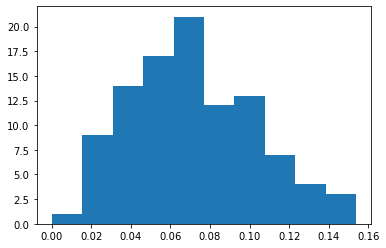

In [36]:
plt.hist(data['bins'][0][:-1], data['bins'][0], weights=data['hist'][0]);

# Обработка данных

In [3]:
DIR = Path.cwd().parent / 'Simulation Results' / 'Geo_Rand_Walk_2D'
files = list(DIR.glob('*.*'))
df = np.array([np.loadtxt(files[0], skiprows=1)])
for f in files[1:]:
    df_0 = np.loadtxt(f, skiprows=1)
    df = np.append(df, [df_0], axis=0)
df = df[np.argsort(df[:,0])]

f = open(files[1], 'r')
for line in f:
    s = line.split()
    break
    
data = pd.DataFrame(df, columns=s)
data['N'] = data['N'].apply(lambda x: int(x))
data['steps'] = data['steps'].apply(lambda x: int(x))
data

,N,n1_mean,n2_mean,n3_mean,n4_mean,uni_mean,n1_std,n2_std,n3_std,n4_std,uni_std,steps
0,100,0.067665,0.335235,0.357256,0.239844,0.490890,0.033152,0.087316,0.066924,0.092123,0.082536,8472000
1,200,0.052231,0.290401,0.353731,0.303637,0.444336,0.022443,0.070376,0.054525,0.089505,0.069596,8426000
2,500,0.039595,0.244218,0.339652,0.376534,0.394385,0.013961,0.053665,0.043817,0.081703,0.056279,7992000
3,1000,0.033331,0.216908,0.326059,0.423702,0.363246,0.010103,0.044156,0.038171,0.074483,0.048394,6846000
4,2500,0.027529,0.188264,0.307217,0.476990,0.328812,0.006911,0.034551,0.032531,0.064819,0.040148,3430000
5,5000,0.024317,0.170852,0.293229,0.511602,0.306759,0.005370,0.029042,0.029183,0.058075,0.035205,1180000
6,10000,0.021778,0.156195,0.279780,0.542247,0.287379,0.004272,0.024617,0.026400,0.051970,0.031147,343000


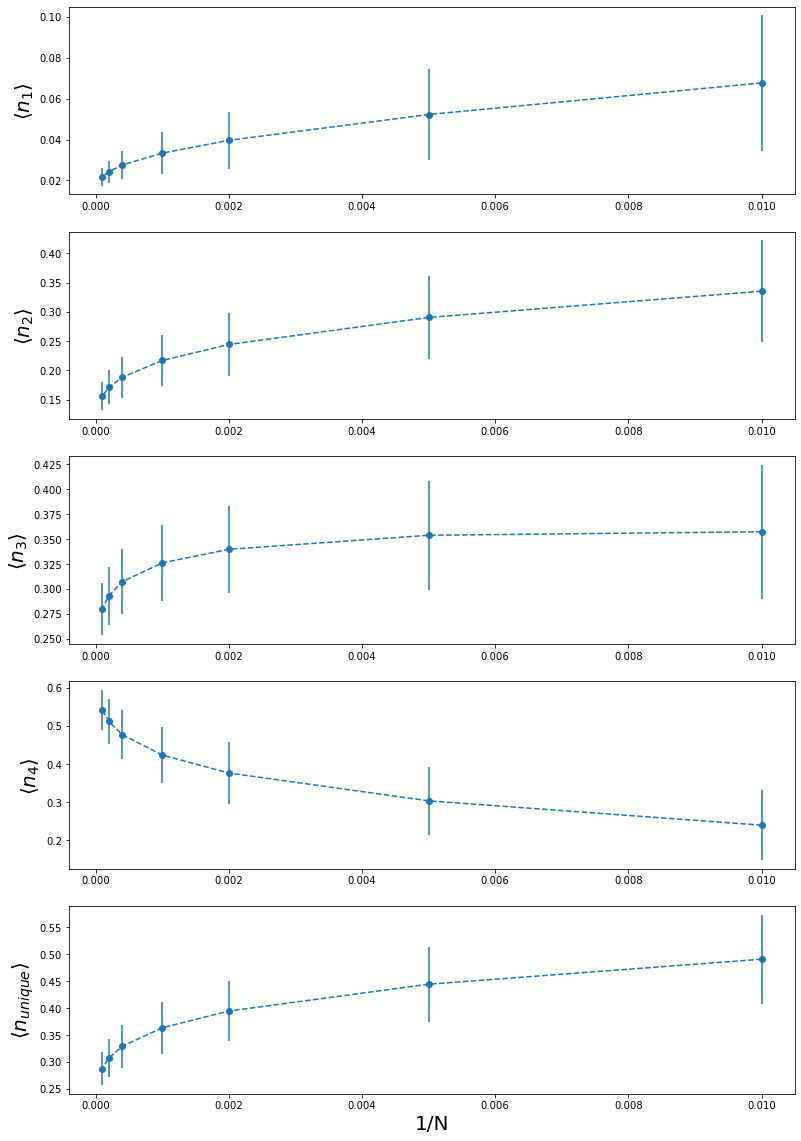

In [4]:
fig, ax = plt.subplots(5,1, figsize=(13,20))
x = 1/df[:,0]
for i in range(5):
    y = df[:,i+1]
    dy = df[:,5+i+1]
    ax[i].errorbar(x, y, dy, fmt='o--')
    if i < 4:
        ax[i].set_ylabel(fr'$\langle n_{i+1} \rangle$', fontsize=20)
    else:
        ax[i].set_ylabel(r'$\langle n_{unique} \rangle$', fontsize=20)
ax[-1].set_xlabel('1/N', fontsize=20);
#plt.savefig(Path.cwd() / 'Images' / 'Rand_Path_N1-4_unique.png')

# Шкалирование

In [263]:
def full_scaling(x, y, dy, n, image_name=None):
    fig, axes = plt.subplots(3, 1, figsize=(13,17), constrained_layout=True)
    fig.suptitle(fr"$n_{n}$ scaling", fontsize=30)
    x_reg = x.copy()
    y_reg = y.copy()
    for i, scaling, ax in zip([0,1,2], [('linear', 'linear'), ('log', 'linear'), ('log', 'log')], axes):
        ax.errorbar(x, y, yerr=dy, fmt="s--", label=fr"MC Data of n={n}")
        ax.set_xscale(scaling[1])
        ax.set_yscale(scaling[0])
        if scaling[0] == 'linear' and scaling[1] == 'linear':
            title = 'linear scaling'
        elif scaling[0] == 'log' and scaling[1] == 'linear':
            title = 'log-linear scaling'
        else:
            title = 'log-log scaling'
        ax.set_title(title, fontsize=20)
        ax.tick_params(labelsize=16, which='both')
        ax.legend()
    axes[-1].set_xlabel('1/N', fontsize=20)
    if image_name != None:
        plt.savefig(Path.cwd() / "Images" / (image_name + ".png"))
    plt.show()

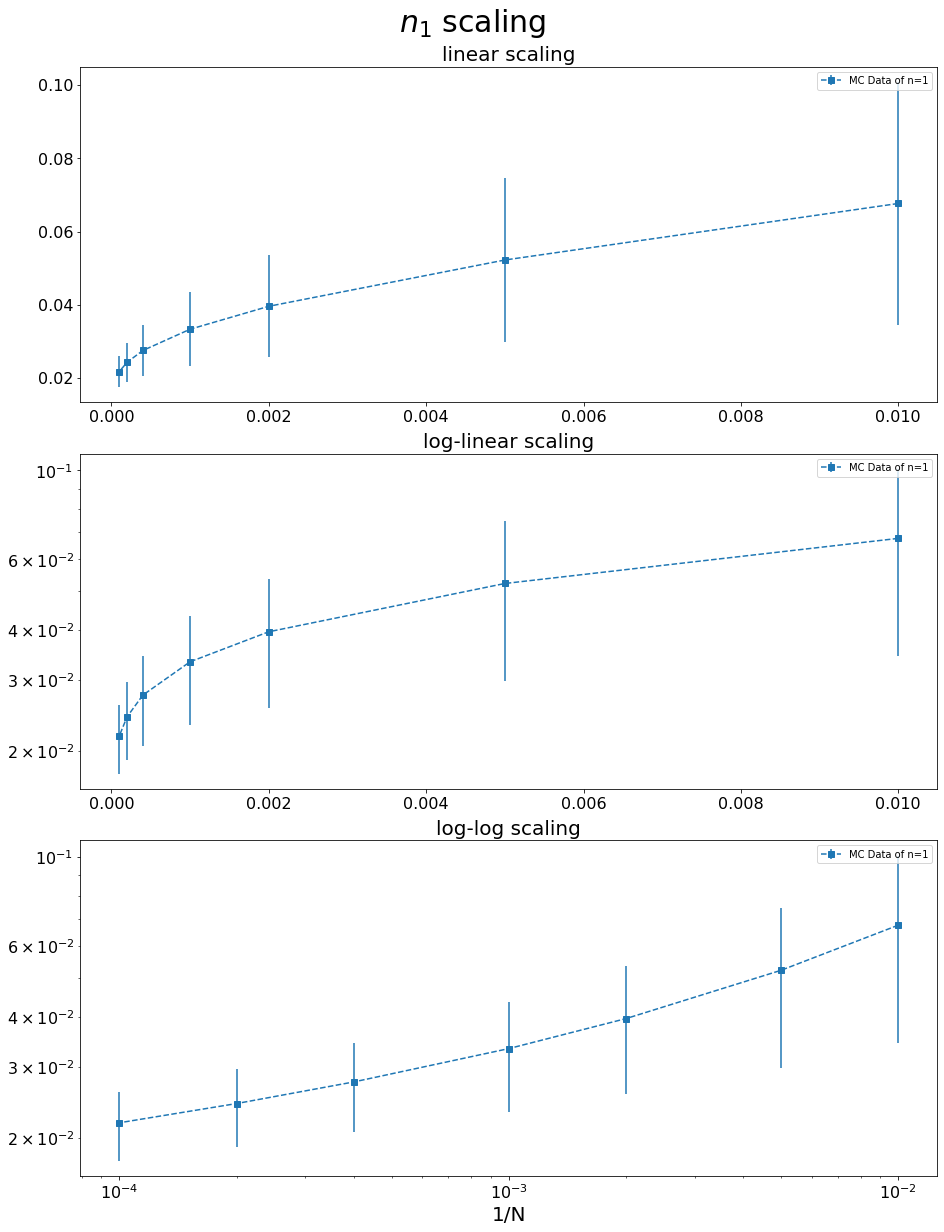

In [264]:
full_scaling(1/data['N'], data['n1_mean'], data['n1_std'], 1)

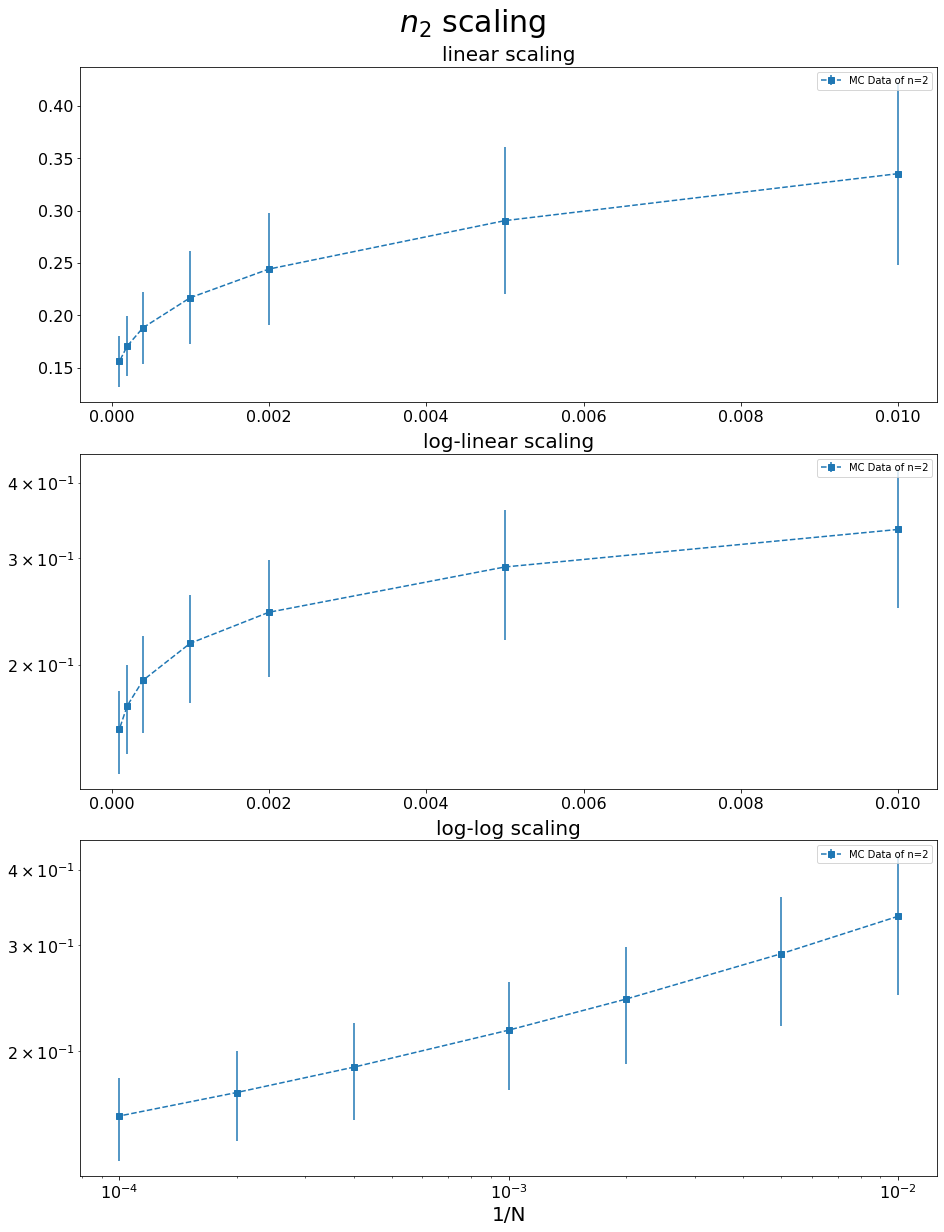

In [265]:
full_scaling(1/data['N'], data['n2_mean'], data['n2_std'], 2)

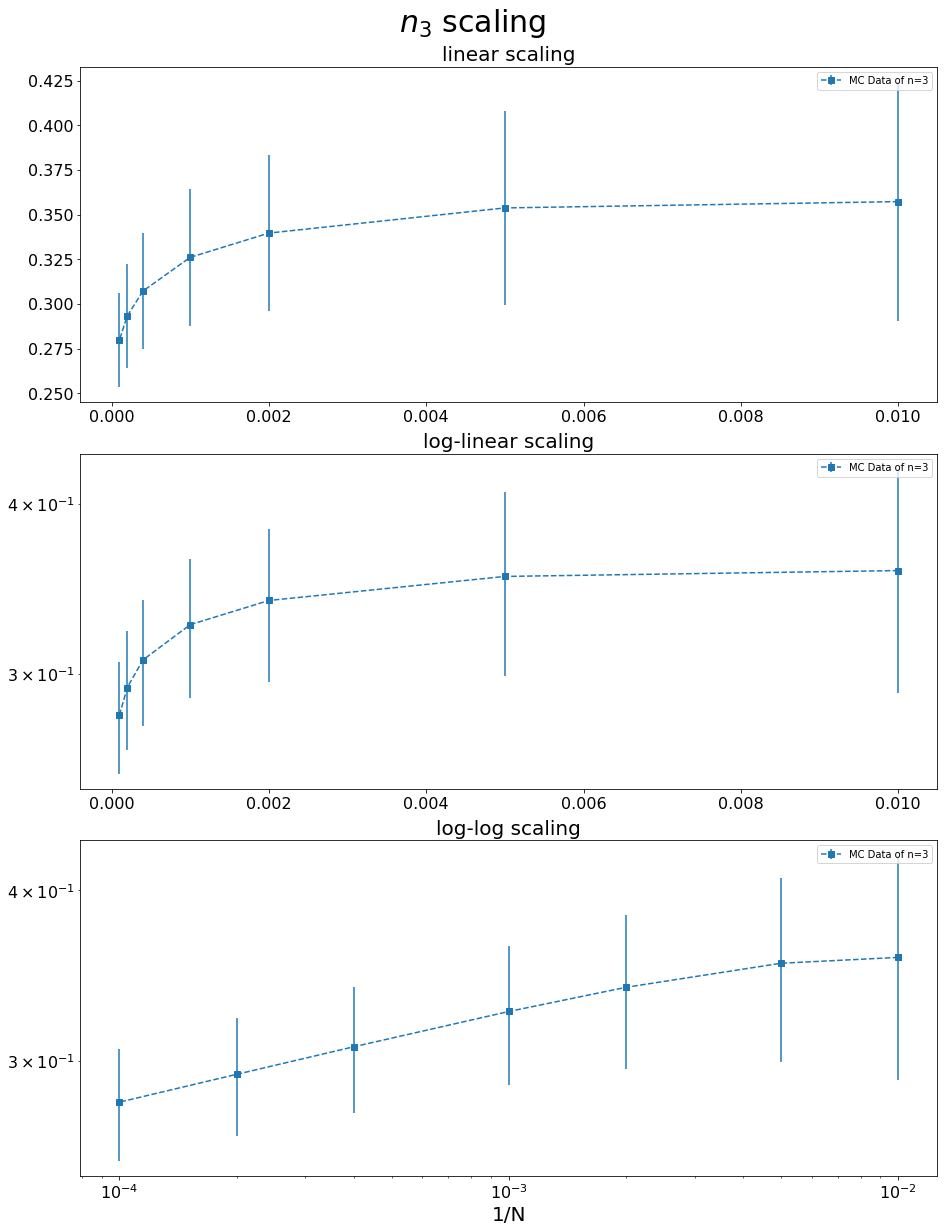

In [266]:
full_scaling(1/data['N'], data['n3_mean'], data['n3_std'], 3)

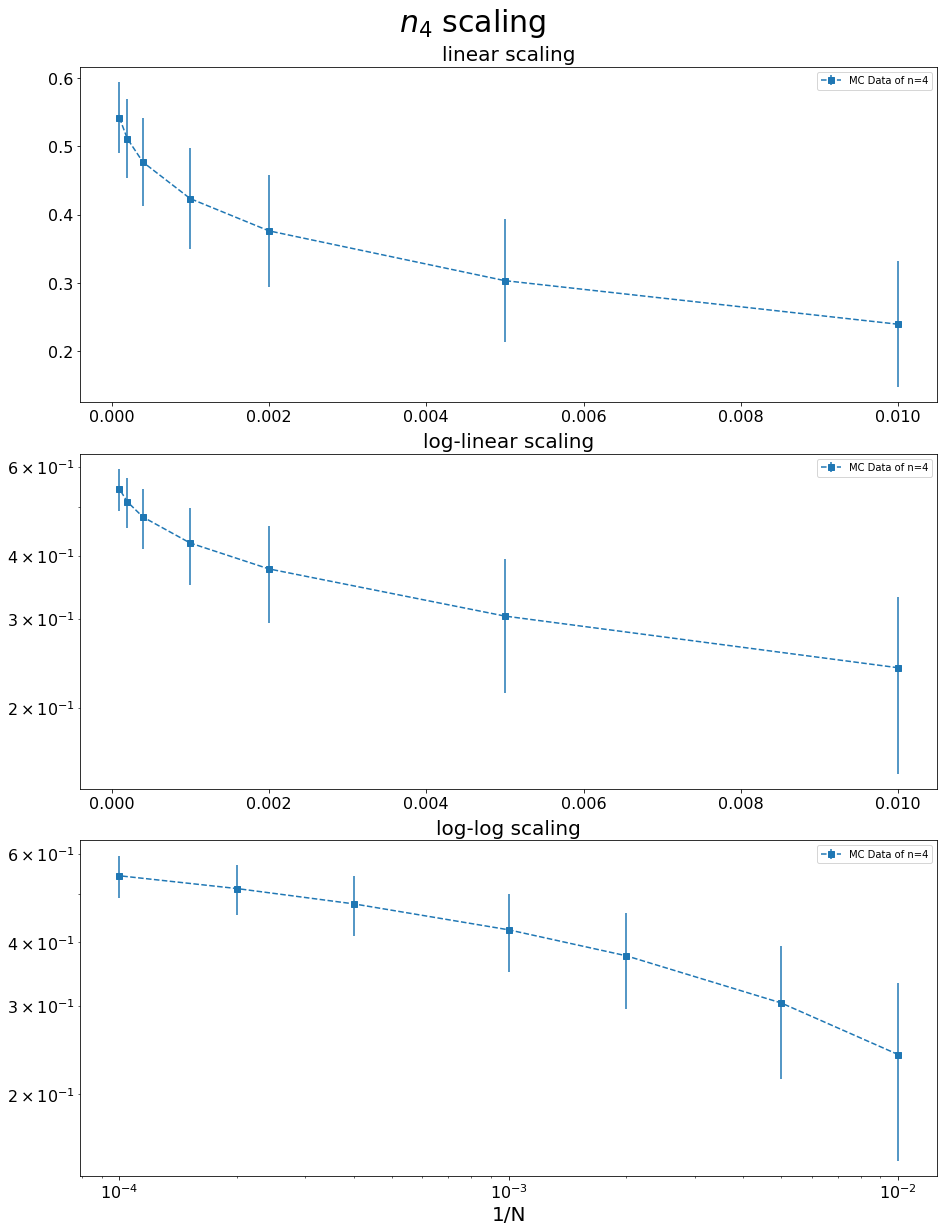

In [267]:
full_scaling(1/data['N'], data['n4_mean'], data['n4_std'], 4)

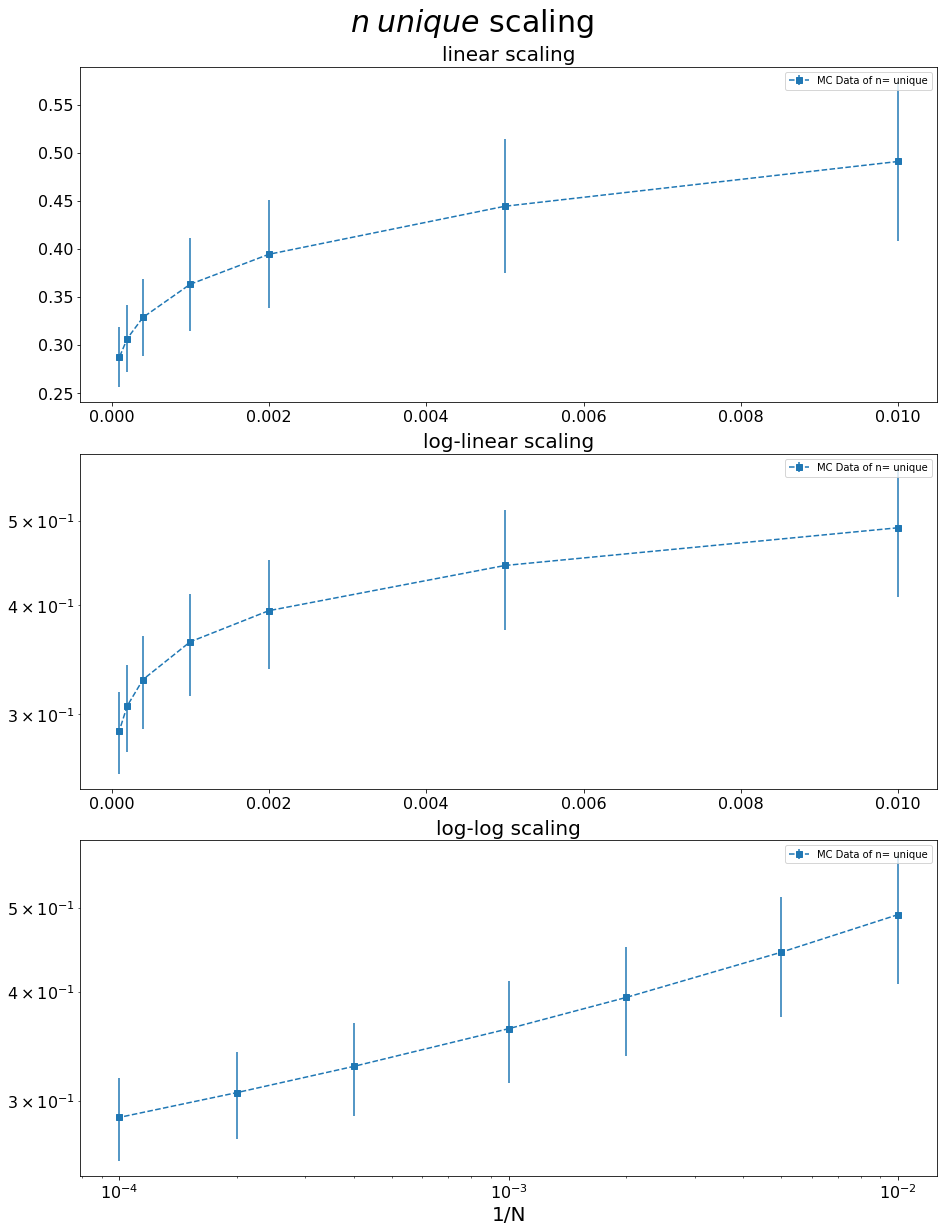

In [268]:
full_scaling(1/data['N'], data['uni_mean'], data['uni_std'], ' unique')

Наилучшие результаты показывает именно степенное шкалирование относительно обратной длины цепочки $1/N$. Уточним результаты на органиченном диапазоне данных:

In [238]:
def f_x_a(x, a):
    return a[0] * x ** a[1] + a[2]

def leastsquares(a, x, y):
    s = 0
    for i in range(len(x)):
        s += (f_x_a(x[i], a) - y[i]) ** 2
    return s

def errFit(hess_inv, resVariance):
    return np.sqrt( np.diag( hess_inv * resVariance))

def log_log_scaling(x, y, dy, a_0=[1,1,0], text_pos=(0.0001,0.07), image_name=None):
    plt.figure(figsize=(15,9))
    plt.errorbar(x,y,dy, fmt='s--')
    res = minimize(leastsquares, a_0, (x,y))
    a = res.x
    da = errFit( res.hess_inv,  res.fun )

    plt.plot(x, a[0] * x ** a[1] + a[2])
    plt.xscale('log')
    plt.yscale('log')
    print(res.success)
    s1 = 'y = k * (1/N)^a + b' + "\n"
    s2 = r'k = %.4f $\pm$ %.4f' % (a[0], da[0]) + '\n'
    s3 = r'a = %.4f $\pm$ %.4f' % (a[1], da[1]) + '\n'
    s4 = r'b = %.4f $\pm$ %.4f' % (a[2], da[2])
    plt.text(*text_pos, s1 + s2 + s3 + s4, fontsize=17, bbox=dict(facecolor='brown', alpha=0.3))
    #print(f'k = %.5f ' % )

True


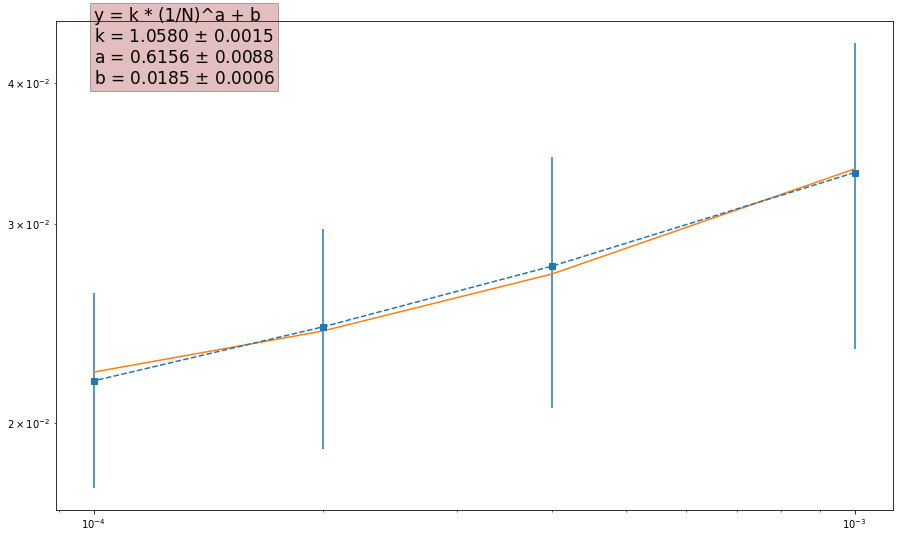

In [269]:
d = data[3:]
x = np.array(1/d['N'])
y = np.array(d['n1_mean'])
dy = np.array(d['n1_std'])
log_log_scaling(x, y, dy, text_pos=(0.0001, 0.04))

True


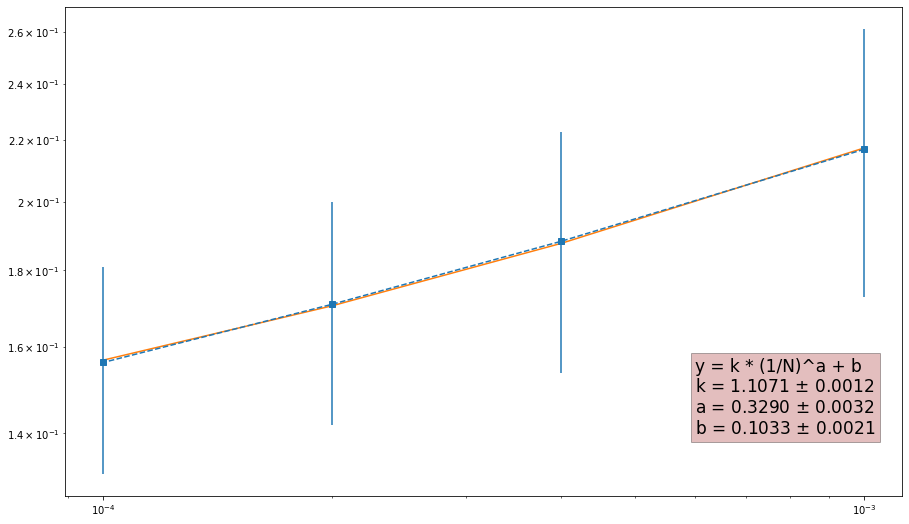

In [279]:
d = data[3:]
x = np.array(1/d['N'])
y = np.array(d['n2_mean'])
dy = np.array(d['n2_std'])
log_log_scaling(x, y, dy, text_pos=(0.0006, 0.14))

True


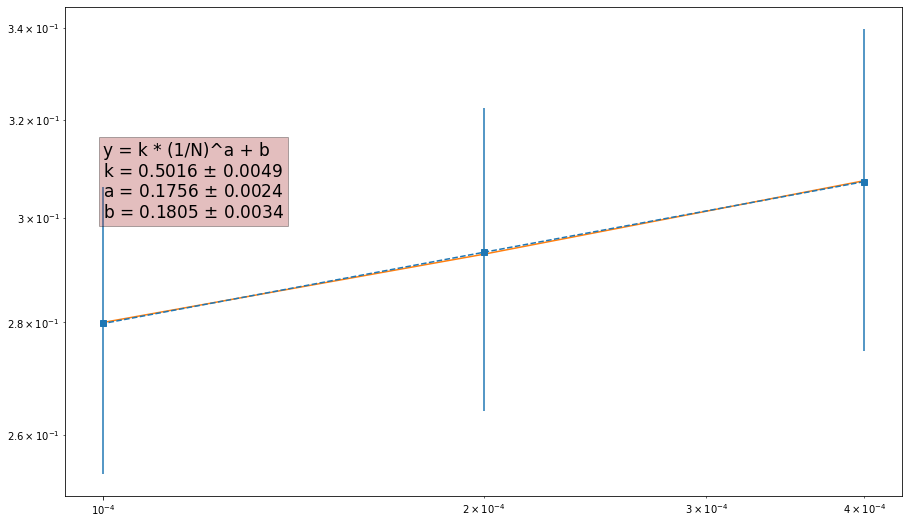

In [294]:
d = data[4:]
x = np.array(1/d['N'])
y = np.array(d['n3_mean'])
dy = np.array(d['n3_std'])
log_log_scaling(x, y, dy, [0.2, 0.5, 0.25], text_pos=(0.0001, 0.3))

True


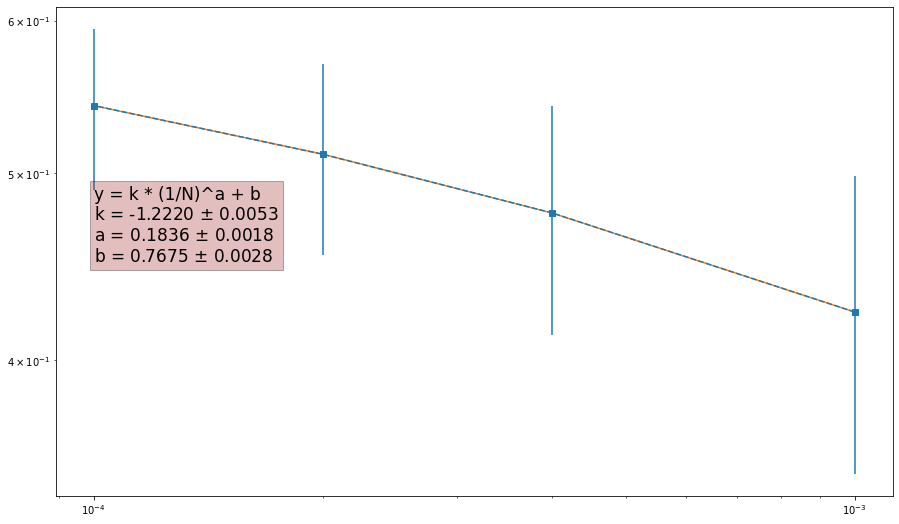

In [273]:
d = data[3:]
x = np.array(1/d['N'])
y = np.array(d['n4_mean'])
dy = np.array(d['n4_std'])
log_log_scaling(x, y, dy, [-1, 0.5, 0], text_pos=(0.0001, 0.45))

True


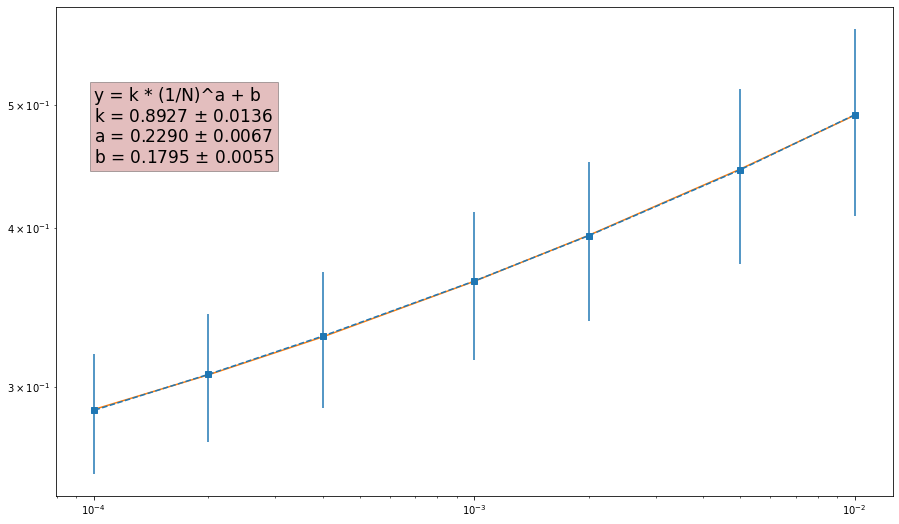

In [258]:
d = data[:]
x = np.array(1/d['N'])
y = np.array(d['uni_mean'])
dy = np.array(d['uni_std'])
log_log_scaling(x, y, dy, [1, 0.5, 0], text_pos=(0.0001, 0.45))